In [105]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter

In [106]:
#Load data
file_path = 'final_data.csv'
data = pd.read_csv(file_path, sep=',')

In [107]:
sequences = data['Sequence'].values
charge = data['Charge'].values
ccs = data['CCS'].values

In [108]:
# Define the 20 standard amino acids and include non-standard ones
amino_acids = 'ACDEFGHIKLMNPQRSTVWYU'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

def one_hot_encode(seq, max_length):
    # Pad the sequence to the maximum length with 'X' (unknown amino acid)
    padded_seq = seq.ljust(max_length, 'X')
    int_encoded = [aa_to_int.get(aa, len(amino_acids)) for aa in padded_seq]  # Use a default index for unknown amino acids
    one_hot_encoded = np.zeros((max_length, len(amino_acids) + 1))  # +1 for the unknown amino acid
    for i, value in enumerate(int_encoded):
        one_hot_encoded[i, value] = 1
    return one_hot_encoded.flatten()

In [109]:
# Determine the maximum sequence length
max_seq_length = max(data['Sequence'].apply(len))

# Encode the sequences
one_hot_encoded_sequences = np.array([one_hot_encode(seq, max_seq_length) for seq in data['Sequence']])

# Initialize the label encoder for charge states
label_encoder = LabelEncoder()
encoded_charge_states = label_encoder.fit_transform(data['Charge'].tolist())

In [110]:

encoded_features = np.hstack((
    one_hot_encoded_sequences,
    encoded_charge_states.reshape(-1, 1),
    
))

In [111]:

normalized_ccs_values = (ccs - ccs.min()) / (ccs.max() - ccs.min())

In [112]:
class AminoAcidDataset(Dataset):
    def __init__(self, sequences, encoded_features, ccs):
        self.sequences = sequences
        self.encoded_features = encoded_features
        self.ccs = ccs

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx].reshape(max_seq_length, -1), dtype=torch.float32)
        encoded_feature = torch.tensor(self.encoded_features[idx], dtype=torch.float32)
        ccs = torch.tensor(self.ccs[idx], dtype=torch.float32)

        return sequence, encoded_feature, ccs




In [113]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, additional_features_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc1 = nn.Linear(hidden_size + additional_features_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, sequence, features):
        batch_size = sequence.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(sequence.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(sequence.device)

        out, _ = self.lstm(sequence, (h0, c0))
        out= self.dropout(out)
        lstm_output = out[:, -1, :]
        combined = torch.cat((lstm_output, features), dim=1)

        out = self.fc1(combined)
        out = self.fc2(out)

        return out




In [114]:
# Hyperparameters
input_size = len(amino_acids) + 1  
hidden_size = 50
num_layers = 2
output_size = 1
additional_features_size = encoded_features.shape[1]  
learning_rate = 0.001
batch_size = 32
num_epochs = 5
dropout_rate = 0.2

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size, additional_features_size, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


LSTMModel(
  (lstm): LSTM(22, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=1195, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [115]:
# Create a DataLoader to batch and shuffle the data
dataset = AminoAcidDataset(one_hot_encoded_sequences, encoded_features, normalized_ccs_values)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [116]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [117]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for sequences, features, ccs in train_loader:
        sequences = sequences.to(device)
        features = features.to(device)
        ccs = ccs.to(device)

        outputs = model(sequences, features)
        loss = criterion(outputs, ccs.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")



Epoch [1/5], Loss: 0.0019
Epoch [2/5], Loss: 0.0009
Epoch [3/5], Loss: 0.0008
Epoch [4/5], Loss: 0.0007
Epoch [5/5], Loss: 0.0007


In [118]:

model.eval()
with torch.no_grad():
    predictions = []
    true_values = []
    for sequences, features, ccs in test_loader:
        sequences = sequences.to(device)
        features = features.to(device)
        ccs = ccs.to(device)

        outputs = model(sequences, features)
        predictions.extend(outputs.cpu().numpy().flatten())
        true_values.extend(ccs.cpu().numpy().flatten())



In [119]:
mse = mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0007
R² Score: 0.9815


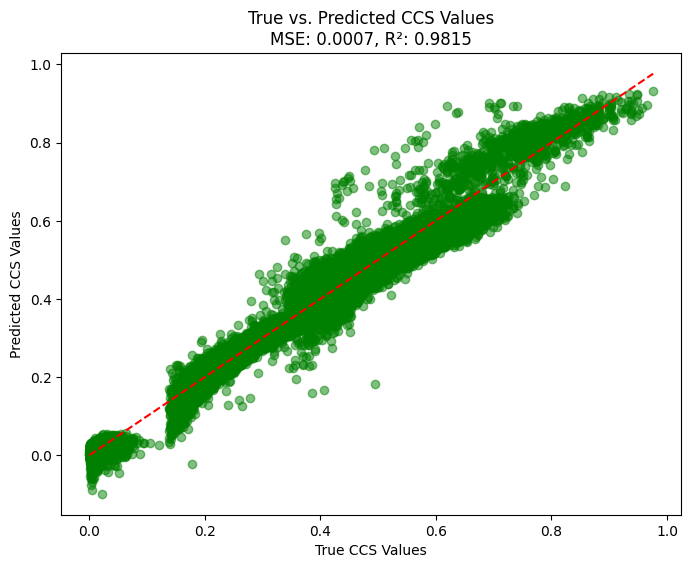

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, color='green', alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--')
plt.xlabel('True CCS Values')
plt.ylabel('Predicted CCS Values')
plt.title(f'True vs. Predicted CCS Values\nMSE: {mse:.4f}, R²: {r2:.4f}')
plt.show()

# Histogram of residuals (errors)
residuals = true_values - predictions
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals (True CCS - Predicted CCS)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
